In [68]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.font_manager as font_manager
import seaborn as sns

import datetime

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_percentage_error, mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import ParameterGrid
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

### 1.Load Data

In [69]:
train_data = pd.read_csv('Google_Stock_Price_Train.csv')
test_set = pd.read_csv('Google_Stock_Price_Test.csv')
display(train_data.shape)
display(test_set.shape)

(1258, 6)

(20, 6)

In [70]:
train_data.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2012,325.25,332.83,324.97,663.59,"7,380,500"
1,1/4/2012,331.27,333.87,329.08,666.45,"5,749,400"
2,1/5/2012,329.83,330.75,326.89,657.21,"6,590,300"
3,1/6/2012,328.34,328.77,323.68,648.24,"5,405,900"
4,1/9/2012,322.04,322.29,309.46,620.76,"11,688,800"


In [71]:
train_data.tail(100)

,Date,Open,High,Low,Close,Volume
1158,8/10/2016,783.75,786.81,782.78,784.68,"786,400"
1159,8/11/2016,785.00,789.75,782.97,784.85,"975,100"
1160,8/12/2016,781.50,783.40,780.40,783.22,"740,500"
1161,8/15/2016,783.75,787.49,780.11,782.44,"938,200"
1162,8/16/2016,780.30,780.98,773.44,777.14,"1,028,000"
...,...,...,...,...,...,...
1253,12/23/2016,790.90,792.74,787.28,789.91,"623,400"
1254,12/27/2016,790.68,797.86,787.66,791.55,"789,100"
1255,12/28/2016,793.70,794.23,783.20,785.05,"1,153,800"
1256,12/29/2016,783.33,785.93,778.92,782.79,"744,300"


In [72]:
test_set.head()

,Date,Open,High,Low,Close,Volume
0,1/3/2017,778.81,789.63,775.80,786.14,"1,657,300"
1,1/4/2017,788.36,791.34,783.16,786.90,"1,073,000"
2,1/5/2017,786.08,794.48,785.02,794.02,"1,335,200"
3,1/6/2017,795.26,807.90,792.20,806.15,"1,640,200"
4,1/9/2017,806.40,809.97,802.83,806.65,"1,272,400"


In [73]:
display(train_data.info())
display(test_set.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1258 entries, 0 to 1257
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    1258 non-null   object 
 1   Open    1258 non-null   float64
 2   High    1258 non-null   float64
 3   Low     1258 non-null   float64
 4   Close   1258 non-null   object 
 5   Volume  1258 non-null   object 
dtypes: float64(3), object(3)
memory usage: 59.1+ KB


None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    20 non-null     object 
 1   Open    20 non-null     float64
 2   High    20 non-null     float64
 3   Low     20 non-null     float64
 4   Close   20 non-null     float64
 5   Volume  20 non-null     object 
dtypes: float64(4), object(2)
memory usage: 1.1+ KB


None

#### 1.1 Check Missing Data

In [74]:
# Check Missing Value
display(train_data.isnull().sum())
display(test_set.isnull().sum())

,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


,0
Date,0
Open,0
High,0
Low,0
Close,0
Volume,0


#### 1.2 Data Types

In [75]:
train_data.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,object
Volume,object


In [76]:
test_set.dtypes

,0
Date,object
Open,float64
High,float64
Low,float64
Close,float64
Volume,object


In [77]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_set['Date'] = pd.to_datetime(test_set['Date'])
# Change Close into float64
train_data['Close'] = train_data['Close'].str.replace(',', '').astype(float)
test_set['Close'] = test_set['Close'].astype(float)

# Change Volume into float64
train_data['Volume'] = train_data['Volume'].str.replace(',', '').astype(float)
test_set['Volume'] = test_set['Volume'].str.replace(',', '').astype(float)

In [78]:
display(train_data.dtypes)
display(test_set.dtypes)

,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Volume,float64


,0
Date,datetime64[ns]
Open,float64
High,float64
Low,float64
Close,float64
Volume,float64


#### 1.3 Data Resmapling

In [79]:
# Group the data by month and count the number of unique days per month
days_per_month_train = train_data.groupby(train_data['Date'].dt.to_period('M'))['Date'].nunique()

# Convert series to dataframe
days_per_month_train = pd.DataFrame(days_per_month_train)
days_per_month_train['Year'] = days_per_month_train.index.to_timestamp().year

# Calculate days per year
days_per_year_train = days_per_month_train.groupby('Year')['Date'].sum()

display(days_per_month_train.head(10))
display(days_per_month_train.shape)

# Output the year separately
print("Years:", days_per_month_train['Year'].unique())

# Output days per year
print("\nDays per year:")
display(days_per_year_train)

,Date,Year
Date,,
2012-01,20,2012
2012-02,20,2012
2012-03,22,2012
2012-04,20,2012
2012-05,22,2012
2012-06,21,2012
2012-07,21,2012
2012-08,23,2012
2012-09,19,2012


(60, 2)

Years: [2012 2013 2014 2015 2016]

Days per year:


,Date
Year,
2012,250
2013,252
2014,252
2015,252
2016,252


In [80]:
# Group the data by month and count the number of unique days per month
days_per_month_test = test_set.groupby(test_set['Date'].dt.to_period('M'))['Date'].nunique()

#convert series to dataframe
days_per_month_test = pd.DataFrame(days_per_month_test)
days_per_month_test['Year'] = days_per_month_test.index.to_timestamp().year
display(days_per_month_test.head())
display(days_per_month_test.shape)

print("Years:", days_per_month_test['Year'].unique())

,Date,Year
Date,,
2017-01,20,2017


(1, 2)

Years: [2017]


### 2.EDA

#### 2.1 Close Abnormal value

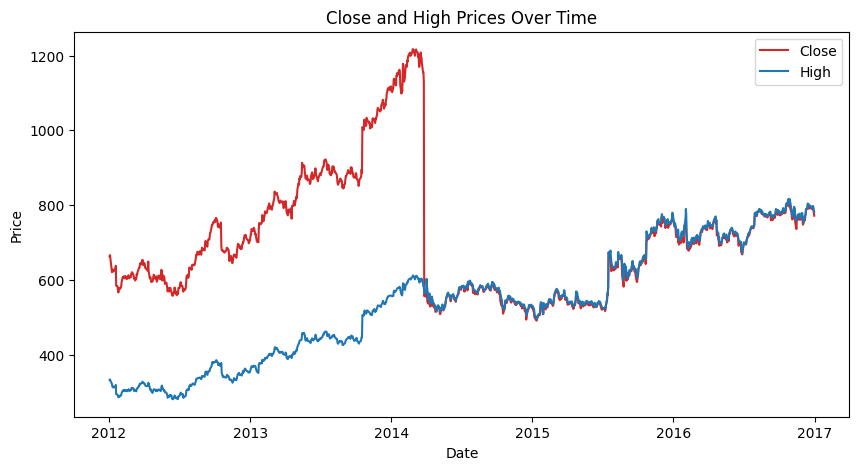

In [81]:
# Plot Close and High
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot 'Close' in red
ax1.plot(train_data['Date'], train_data['Close'], color='tab:red', label='Close')

# Plot 'High' in blue
ax1.plot(train_data['Date'], train_data['High'], color='tab:blue', label='High')

# Set labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')  # Shared y-axis label
ax1.set_title('Close and High Prices Over Time')

# Add legend
ax1.legend()

# Display the plot
plt.show()

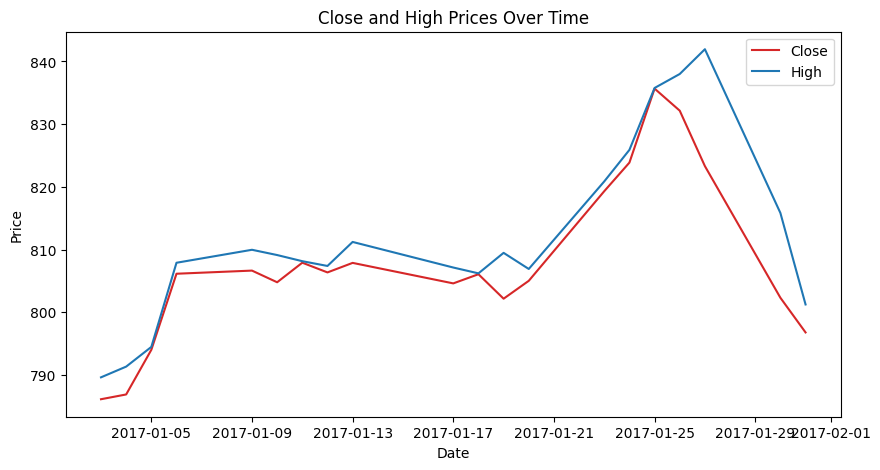

In [82]:
# Plot Close and High
fig2, ax12 = plt.subplots(figsize=(10, 5))

# Plot 'Close' in red
ax12.plot(test_set['Date'], test_set['Close'], color='tab:red', label='Close')

# Plot 'High' in blue
ax12.plot(test_set['Date'], test_set['High'], color='tab:blue', label='High')

# Set labels and title
ax12.set_xlabel('Date')
ax12.set_ylabel('Price')  # Shared y-axis label
ax12.set_title('Close and High Prices Over Time')

# Add legend
ax12.legend()

# Display the plot
plt.show()

In [83]:
# Apply change in Close
train_data['Close'] = train_data.apply(lambda x: x['Close']/2 if x['Close'] > x['High'] else x['Close'], axis=1)

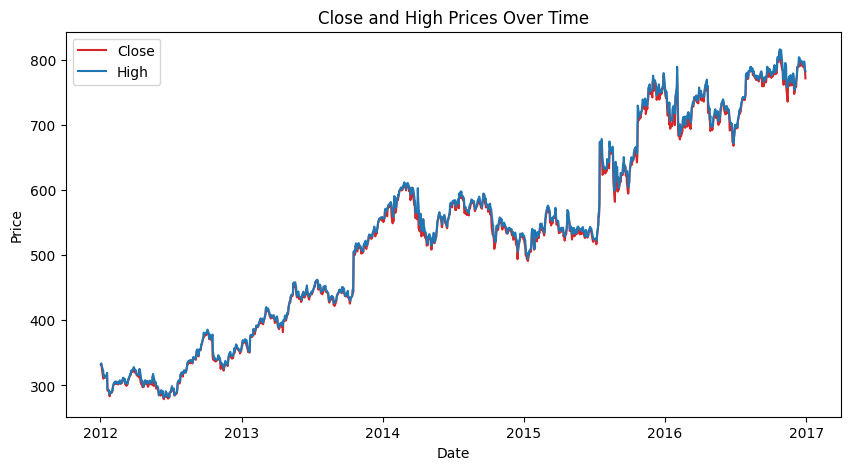

In [84]:
# Plot Close and High
fig, ax1 = plt.subplots(figsize=(10, 5))

# Plot 'Close' in red
ax1.plot(train_data['Date'], train_data['Close'], color='tab:red', label='Close')

# Plot 'High' in blue
ax1.plot(train_data['Date'], train_data['High'], color='tab:blue', label='High')

# Set labels and title
ax1.set_xlabel('Date')
ax1.set_ylabel('Price')  # Shared y-axis label
ax1.set_title('Close and High Prices Over Time')

# Add legend
ax1.legend()

# Display the plot
plt.show()

#### 2.2 Feature Selection

In [85]:
display(train_data.describe().T)
display(test_set.describe().T)

,count,mean,min,25%,50%,75%,max,std
Date,1258,2014-07-03 20:00:45.786963456,2012-01-03 00:00:00,2013-04-05 18:00:00,2014-07-05 00:00:00,2015-10-01 18:00:00,2016-12-30 00:00:00,NaN
Open,1258.0,533.709833,279.12,404.115,537.47,654.9225,816.68,151.904442
High,1258.0,537.880223,281.21,406.765,540.75,662.5875,816.68,153.008811
Low,1258.0,529.007409,277.22,401.765,532.99,644.8,805.14,150.552807
Close,1258.0,533.712258,278.76,404.5275,537.5325,652.1725,813.11,151.618792
Volume,1258.0,3158106.756757,7900.0,1621700.0,2566150.0,4122500.0,24977900.0,2273725.584816


,count,mean,min,25%,50%,75%,max,std
Date,20,2017-01-16 15:36:00,2017-01-03 00:00:00,2017-01-09 18:00:00,2017-01-17 12:00:00,2017-01-24 06:00:00,2017-01-31 00:00:00,NaN
Open,20.0,807.526,778.81,802.965,806.995,809.56,837.81,15.125428
High,20.0,811.9265,789.63,806.735,808.64,817.0975,841.95,14.381198
Low,20.0,801.9495,775.8,797.4275,801.53,804.4775,827.01,13.278607
Close,20.0,807.9045,786.14,802.2825,806.11,810.76,835.67,13.210088
Volume,20.0,1659895.0,919300.0,1248500.0,1418050.0,1743400.0,3246600.0,677474.740236


#### 2.3 Data Set Properties

In [86]:
train_data['Date'] = pd.to_datetime(train_data['Date'])
test_set['Date'] = pd.to_datetime(test_set['Date'])

# Extract the month and year from the 'Date' column
train_data['Month'] = train_data['Date'].dt.month
train_data['Year'] = train_data['Date'].dt.year

test_set['Month'] = test_set['Date'].dt.month
test_set['Year'] = test_set['Date'].dt.year


# Calculate the mean close price per month
monthly_mean = train_data.groupby([ 'Month'])['Close'].mean().reset_index()


# Calculate the mean close price per year
yearly_mean = train_data.groupby([ 'Year'])['Close'].mean().reset_index()

In [87]:
monthly_mean

,Month,Close
0,1,490.998960
1,2,505.327165
2,3,520.527617
3,4,504.974238
4,5,500.968774
5,6,506.466698
6,7,527.471729
7,8,549.333409
8,9,559.243039
9,10,564.289591


<ipython-input-88-2aea80ef07dc>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=monthly_mean, x='Month', y='Close', palette='Set2', ax=ax1)


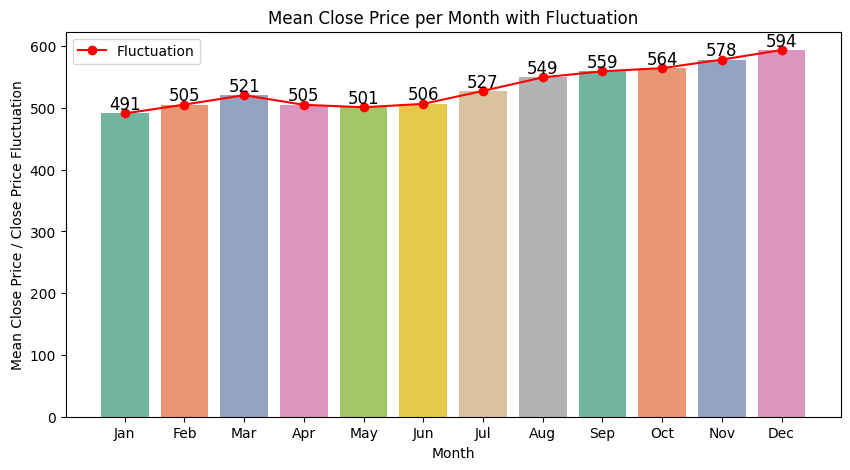

In [88]:
import calendar
# Calculate monthly mean close price
monthly_mean = train_data.groupby(train_data['Date'].dt.month)['Close'].mean().reset_index()
monthly_mean['Month'] = monthly_mean['Date'].apply(lambda x: calendar.month_abbr[x])  # Convert month number to month abbreviation

# Plot the mean close price per month using a Seaborn bar chart
fig, ax1 = plt.subplots(figsize=(10, 5))

ax = sns.barplot(data=monthly_mean, x='Month', y='Close', palette='Set2', ax=ax1)

plt.title('Mean Close Price per Month with Fluctuation')
plt.xlabel('Month')
plt.ylabel('Mean Close Price / Close Price Fluctuation')  # Shared y-axis label

plt.xticks(range(0, 12), labels=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])

for bars in ax.containers:
    ax.bar_label(bars, fontsize=12, fmt='%.f')

# Plot the line chart on the same axes (ax1)
ax1.plot(monthly_mean['Month'], monthly_mean['Close'], color='red', label='Fluctuation', marker='o')  # Added marker for better visibility

# Add legend
ax1.legend()

plt.show()

In [89]:
yearly_mean.head()

,Year,Close
0,2012,320.528480
1,2013,440.910873
2,2014,559.937738
3,2015,602.005556
4,2016,743.486706


<ipython-input-90-4a68de94950d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=yearly_mean, x='Year', y='Close',  palette='Set2')


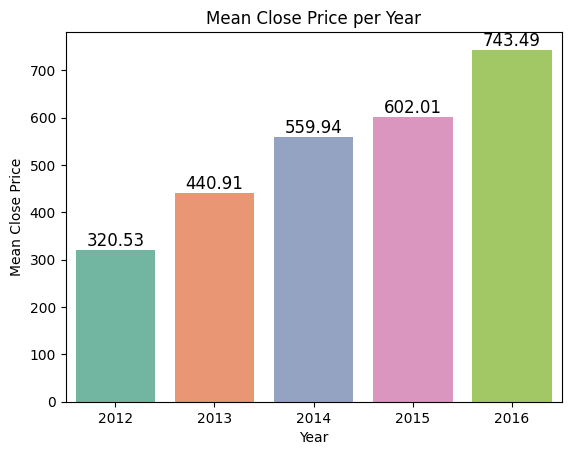

In [90]:
lst_year= yearly_mean['Year'].tolist()

# Plot the mean close price per month using a Seaborn bar chart
ax = sns.barplot(data=yearly_mean, x='Year', y='Close',  palette='Set2')

plt.title('Mean Close Price per Year')
plt.xlabel('Year')
plt.ylabel('Mean Close Price')

plt.xticks(range(0, len(lst_year)), labels=lst_year)

for bars in ax.containers:
     ax.bar_label(bars, fontsize=12, fmt='%.2f')

plt.show()

In [91]:
train_data.head()

,Date,Open,High,Low,Close,Volume,Month,Year
0,2012-01-03,325.25,332.83,324.97,331.795,7380500.0,1,2012
1,2012-01-04,331.27,333.87,329.08,333.225,5749400.0,1,2012
2,2012-01-05,329.83,330.75,326.89,328.605,6590300.0,1,2012
3,2012-01-06,328.34,328.77,323.68,324.120,5405900.0,1,2012
4,2012-01-09,322.04,322.29,309.46,310.380,11688800.0,1,2012


##### 2.3.1 Seasonality

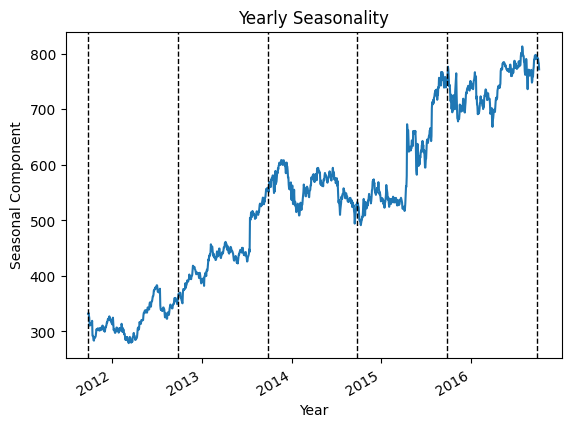

<Figure size 1000x500 with 0 Axes>

In [92]:
# Year
fig, ax = plt.subplots()

ax.plot(train_data['Close'])
for i in np.arange(0, len(train_data), 250):
    ax.axvline(x=i, linestyle='--', color='black', linewidth=1)

plt.title('Yearly Seasonality')
plt.xlabel('Year')
plt.ylabel('Seasonal Component')

plt.xticks(np.arange(67, len(train_data), 250), np.arange(2012, 2017, 1))

plt.figure(figsize=(10, 5))

fig.autofmt_xdate()
plt.tight_layout()

<ipython-input-93-56d41d4b1ad8>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_data = df_seasonality['Close'].resample('M').mean()


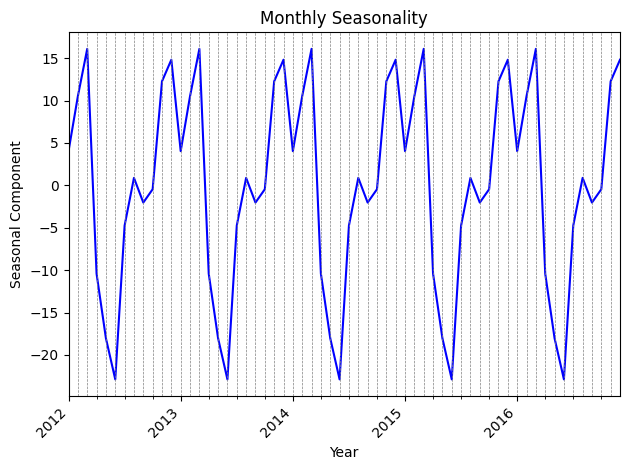

In [93]:
import statsmodels.api as sm
# Month
df_seasonality = train_data.copy()
df_seasonality.set_index('Date', inplace=True)

monthly_data = df_seasonality['Close'].resample('M').mean()

decomposition = sm.tsa.seasonal_decompose(monthly_data, model='additive')
fig, ax = plt.subplots()
decomposition.seasonal.plot(ax=ax, color='blue', linewidth=1.5)
monthly_ticks = monthly_data.index

for tick in monthly_ticks:
    ax.axvline(x=tick, linestyle='--', color='gray', linewidth=0.5)

years = np.arange(monthly_data.index[0].year, monthly_data.index[-1].year + 1)
year_ticks = pd.date_range(start=f'{years[0]}-01', end=f'{years[-1]}-01', freq='YS')

ax.set_xticks(year_ticks)
ax.set_xticklabels(year_ticks.year, rotation=45, ha='right', fontsize=10)

plt.title('Monthly Seasonality', fontsize=12)
plt.xlabel('Year', fontsize=10)
plt.ylabel('Seasonal Component', fontsize=10)

plt.tight_layout()
plt.show()


##### 2.3.2 Trend

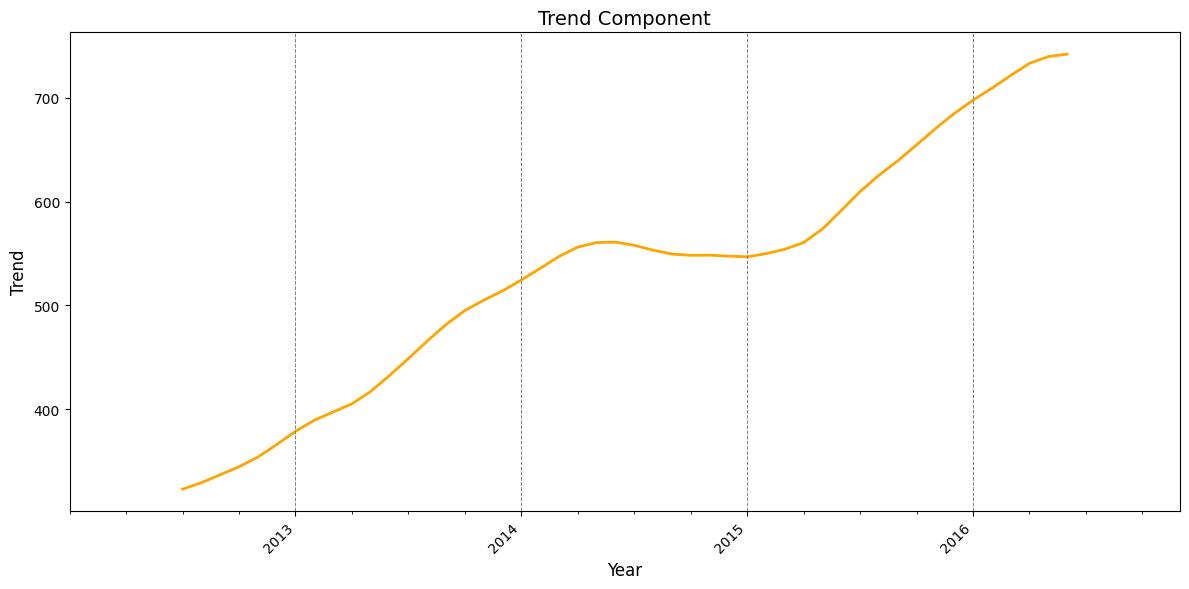

In [94]:
fig, ax = plt.subplots(figsize=(12, 6))

decomposition.trend.plot(ax=ax, color='orange', linewidth=2)
year_ticks = pd.date_range(start=decomposition.trend.index[0],
                           end=decomposition.trend.index[-1], freq='YS')

for tick in year_ticks:
    ax.axvline(x=tick, linestyle='--', color='gray', linewidth=0.7)

ax.set_xticks(year_ticks)
ax.set_xticklabels(year_ticks.year, rotation=45, ha='right', fontsize=10)

plt.title('Trend Component', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Trend', fontsize=12)

plt.tight_layout()
plt.show()

##### 2.3.3 ADF Test

In [95]:
from statsmodels.tsa.stattools import adfuller

# Perform ADF test
result = adfuller(decomposition.observed.dropna())

# Print the test result
print("ADF Statistic:", result[0])
print("p-value:", result[1])
print("Critical Values:", result[4])

# Interpret the result
if result[1] <= 0.05:
    print("The time series is stationary (reject the null hypothesis).")
else:
    print("The time series is not stationary (fail to reject the null hypothesis).")

ADF Statistic: -0.3325639360656429
p-value: 0.9207640056928573
Critical Values: {'1%': -3.5506699942762414, '5%': -2.913766394626147, '10%': -2.5946240473991997}
The time series is not stationary (fail to reject the null hypothesis).


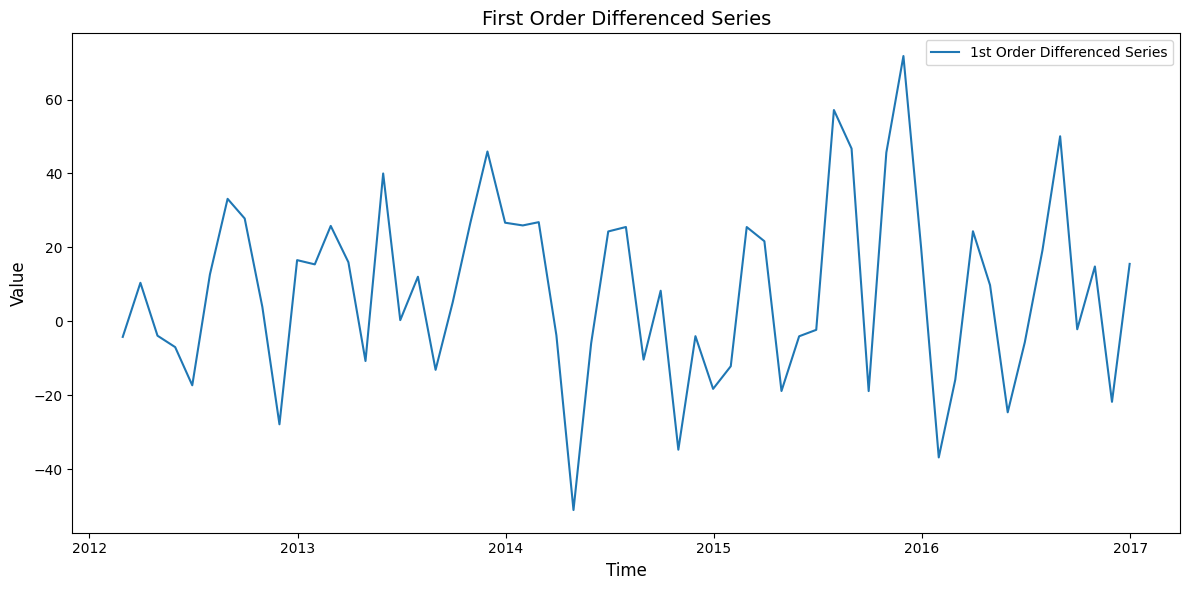

ADF Statistic (Differenced): -6.31372341039487
p-value (Differenced): 3.18809654780263e-08


In [96]:
# First-order differencing
diff_data = decomposition.observed.diff().dropna()

# Plot the differenced series
plt.figure(figsize=(12, 6))
plt.plot(diff_data, label='1st Order Differenced Series')
plt.title('First Order Differenced Series', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# Perform ADF test on differenced series
result_diff = adfuller(diff_data)
print("ADF Statistic (Differenced):", result_diff[0])
print("p-value (Differenced):", result_diff[1])

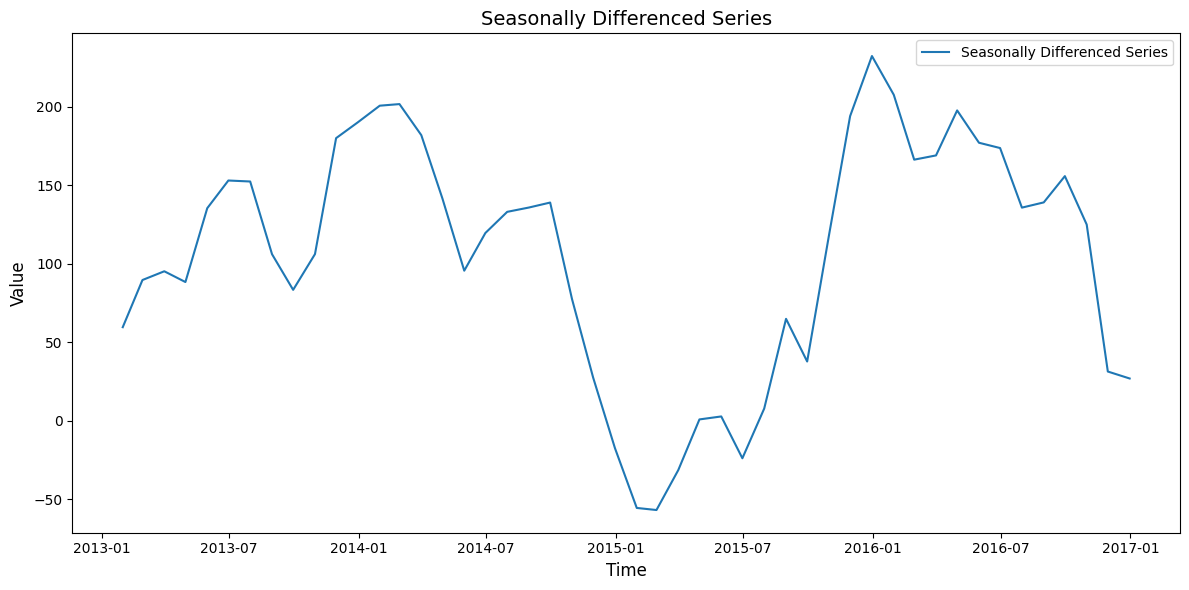

ADF Statistic (Seasonally Differenced): -3.912345568112325
p-value (Seasonally Differenced): 0.0019458459308097935


In [97]:
# Seasonality
# Perform seasonal differencing (lag=12 for monthly data)
seasonal_diff_data = decomposition.observed.diff(12).dropna()

# Plot the seasonally differenced series
plt.figure(figsize=(12, 6))
plt.plot(seasonal_diff_data, label='Seasonally Differenced Series')
plt.title('Seasonally Differenced Series', fontsize=14)
plt.xlabel('Time', fontsize=12)
plt.ylabel('Value', fontsize=12)
plt.legend()
plt.tight_layout()
plt.show()

# Perform ADF test on seasonally differenced data
from statsmodels.tsa.stattools import adfuller
result_seasonal_diff = adfuller(seasonal_diff_data)
print("ADF Statistic (Seasonally Differenced):", result_seasonal_diff[0])
print("p-value (Seasonally Differenced):", result_seasonal_diff[1])

##### 2.3.3 Autocorrelation and Partial Autocorrelation

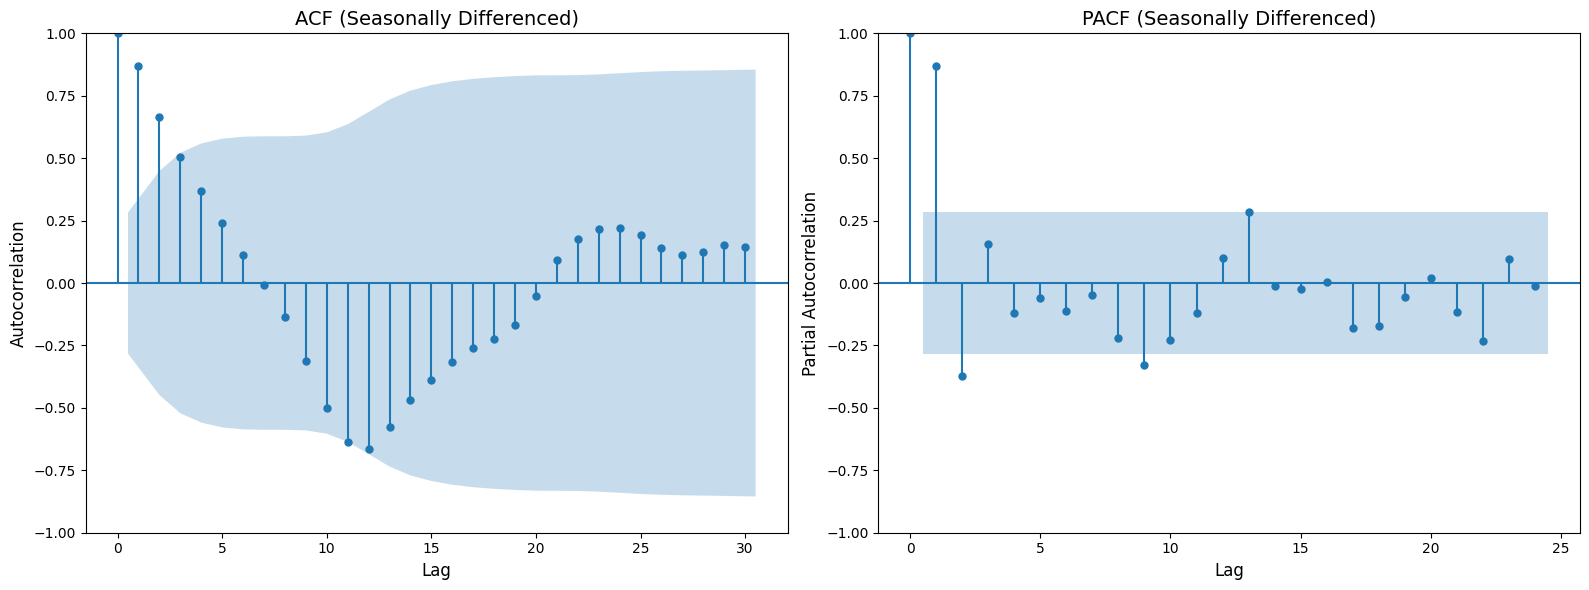

In [98]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Plot ACF and PACF for the seasonally differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ACF plot
plot_acf(seasonal_diff_data, lags=30, ax=axes[0])
axes[0].set_title('ACF (Seasonally Differenced)', fontsize=14)
axes[0].set_xlabel('Lag', fontsize=12)
axes[0].set_ylabel('Autocorrelation', fontsize=12)

# PACF plot
plot_pacf(seasonal_diff_data, lags=24, ax=axes[1], method='ywm')
axes[1].set_title('PACF (Seasonally Differenced)', fontsize=14)
axes[1].set_xlabel('Lag', fontsize=12)
axes[1].set_ylabel('Partial Autocorrelation', fontsize=12)

plt.tight_layout()
plt.show()

| **pqd**      | **PDQs**      |
|--------------|---------------|
| p=1          | P=0           |
| q=1 or 2     | D=1           |
| d=1          | Q=1           |
|              | s=12          |




### 3.Data Preprocessing

In [99]:
train_set_close = train_data[['Close']].values.astype('float32')
train_set_volume = train_data[['Volume']].values.astype('float32')
test_set_close = test_set[['Close']].values.astype('float32')
test_set_volume = test_set[['Volume']].values.astype('float32')

In [100]:
def create_sequence(dataset):
    sequences = []
    labels = []
    for i in range(len(dataset) - 10):  # Loop until 10 elements from the end
        sequences.append(dataset[i:i+10])
        labels.append(dataset[i+10])
    return np.array(sequences), np.array(labels)


In [101]:
# Scale data
scaler_close = MinMaxScaler(feature_range=(0, 1))
scaler_volume = MinMaxScaler(feature_range=(0, 1))
train_set_scaled_close = scaler_close.fit_transform(train_set_close)
train_set_scaled_volume = scaler_volume.fit_transform(train_set_volume)
test_set_scaled_close = scaler_close.transform(test_set_close)
test_set_scaled_volume = scaler_volume.transform(test_set_volume)

In [102]:
# Splitting dataset into train (2012-2015), validation (2016) and test sets
timesteps = 18

# Train (2012-2015), Validation (2016), and Test (2017 onward)
train_data_filtered = train_data[(train_data['Year'] >= 2012) & (train_data['Year'] <= 2015)]
val_data_filtered = train_data[train_data['Year'] == 2016]
test_data_filtered = test_set

train_set_close = train_data_filtered[['Close']].values.astype('float32')
val_set_close = val_data_filtered[['Close']].values.astype('float32')
test_set_close = test_data_filtered[['Close']].values.astype('float32')

train_set_volume = train_data_filtered[['Volume']].values.astype('float32')
val_set_volume = val_data_filtered[['Volume']].values.astype('float32')
test_set_volume = test_data_filtered[['Volume']].values.astype('float32')

In [103]:
# Scale data
scaler_close = MinMaxScaler(feature_range=(0, 1))
train_set_scaled_close = scaler_close.fit_transform(train_set_close)
val_set_scaled_close = scaler_close.transform(val_set_close)
test_set_scaled_close = scaler_close.transform(test_set_close)

scaler_volume = MinMaxScaler(feature_range=(0, 1))
train_set_scaled_volume = scaler_volume.fit_transform(train_set_volume)
val_set_scaled_volume = scaler_volume.transform(val_set_volume)
test_set_scaled_volume = scaler_volume.transform(test_set_volume)

In [104]:
# Function to create time series data
def create_time_series_data(data, timesteps):
    X, y = [], []
    for i in range(timesteps, len(data)):
        X.append(data[i-timesteps:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

In [105]:
# Create time series data
timesteps = 18
X_train_close, y_train_close = create_time_series_data(train_set_scaled_close, timesteps)
X_val_close, y_val_close = create_time_series_data(val_set_scaled_close, timesteps)
X_test_close, y_test_close = create_time_series_data(test_set_scaled_close, timesteps)

X_train_volume, y_train_volume = create_time_series_data(train_set_scaled_volume, timesteps)
X_val_volume, y_val_volume = create_time_series_data(val_set_scaled_volume, timesteps)
X_test_volume, y_test_volume = create_time_series_data(test_set_scaled_volume, timesteps)

In [106]:
# Reshape for RNN/LSTM input
X_train_close = X_train_close.reshape((X_train_close.shape[0], X_train_close.shape[1], 1))
X_val_close = X_val_close.reshape((X_val_close.shape[0], X_val_close.shape[1], 1))
X_test_close = X_test_close.reshape((X_test_close.shape[0], X_test_close.shape[1], 1))

X_train_volume = X_train_volume.reshape((X_train_volume.shape[0], X_train_volume.shape[1], 1))
X_val_volume = X_val_volume.reshape((X_val_volume.shape[0], X_val_volume.shape[1], 1))
X_test_volume = X_test_volume.reshape((X_test_volume.shape[0], X_test_volume.shape[1], 1))

### 4.Functions for Modeling

#### 4.2 Evaluation

In [107]:
def train_and_evaluate(model, X_train, y_train, X_val, y_val, X_test, y_test, model_name):
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size, verbose=1, callbacks=[early_stopping])

    # Plot loss curve
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(f'{model_name} Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Predict on validation set
    y_val_pred = model.predict(X_val)
    y_val_pred = scaler_close.inverse_transform(y_val_pred.reshape(-1, 1))
    y_val_rescaled = scaler_close.inverse_transform(y_val.reshape(-1, 1))

    # Plot predictions vs actual for validation set
    plt.plot(y_val_rescaled, label='Actual (Validation)')
    plt.plot(y_val_pred, label='Predicted (Validation)')
    plt.title(f'{model_name} Predictions vs Actual on Validation Set')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

    # Predict on test set
    y_pred = model.predict(X_test)
    y_pred = scaler_close.inverse_transform(y_pred.reshape(-1, 1))
    y_test_rescaled = scaler_close.inverse_transform(y_test.reshape(-1, 1))

    # Evaluation metrics
    mape = mean_absolute_percentage_error(y_test_rescaled, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test_rescaled, y_pred))
    r2 = r2_score(y_test_rescaled, y_pred)
    mae = mean_absolute_error(y_test_rescaled, y_pred)

    print(f'{model_name} Evaluation Metrics:')
    print(f'MAPE: {mape}')
    print(f'RMSE: {rmse}')
    print(f'R^2: {r2}')
    print(f'MAE: {mae}')

    # Plot predictions vs actual for test set
    plt.plot(y_test_rescaled, label='Actual (Test)')
    plt.plot(y_pred, label='Predicted (Test)')
    plt.title(f'{model_name} Predictions vs Actual on Test Set')
    plt.xlabel('Samples')
    plt.ylabel('Values')
    plt.legend()
    plt.show()

### 5.Modeling

#### 5.1 Baseline Model(Vanilla RNN)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 48ms/step - loss: 0.0866 - val_loss: 0.0611
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0065 - val_loss: 0.0213
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0029 - val_loss: 0.0081
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0020 - val_loss: 0.0041
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0019 - val_loss: 0.0035
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0021 - val_loss: 0.0035
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 0.0032
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0015 - val_loss: 0.0027
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0016 - val_loss: 0.0025
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0021
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0013 - val_loss: 0.0024

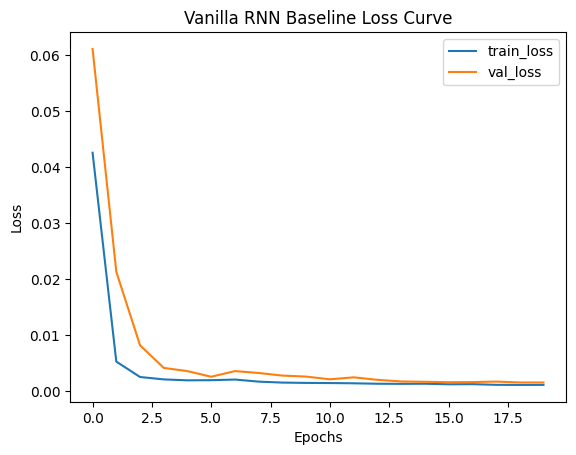

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step


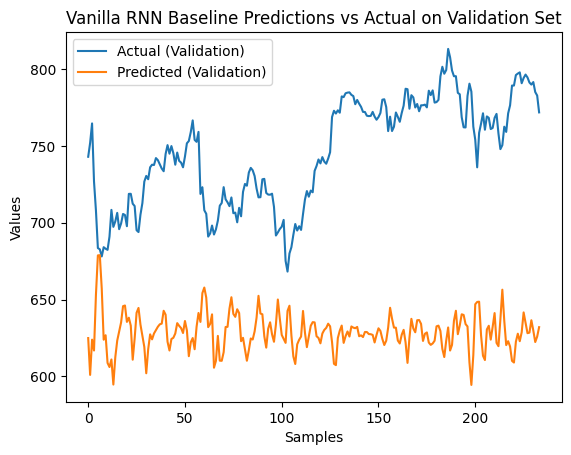

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
Vanilla RNN Baseline Evaluation Metrics:
MAPE: 0.2036673128604889
RMSE: 163.1831512451172
R^2: -3482.0185546875
MAE: 162.87588500976562


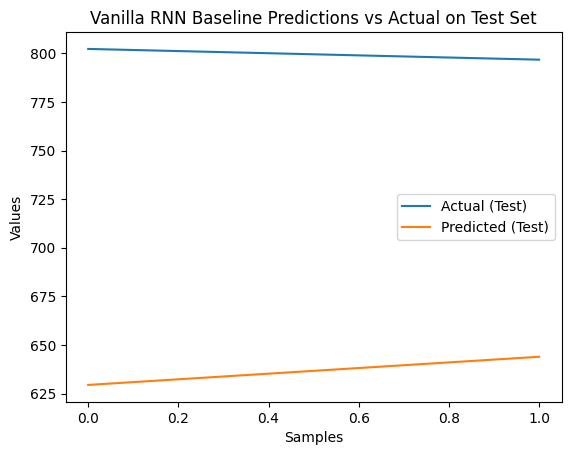

In [133]:
# Function to build Vanilla RNN baseline model
def build_vanilla_rnn_baseline():
    model = Sequential()
    model.add(SimpleRNN(32, activation='tanh', input_shape=(X_train_close.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    return model

# Train and evaluate Vanilla RNN baseline model
vanilla_rnn_model = build_vanilla_rnn_baseline()
train_and_evaluate(vanilla_rnn_model, X_train_close, y_train_close, X_val_close, y_val_close, X_test_close, y_test_close, 'Vanilla RNN Baseline')

### 6.Hyperparameter Tuning

In [116]:
# Parameter grid for hyperparameter tuning
param_grid = {
    'units': [32, 64],
    'activation_function': ['tanh'],
    'learning_rate': [0.001, 0.01, 0.1],
    'batch_size': [32, 64],
    'optimizer': ['adam']
}
grid = ParameterGrid(param_grid)

In [129]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)

#### 6.1 RNN

In [118]:
# Function to build RNN model
def build_rnn_model(units, activation_function,  learning_rate, optimizer_name):
    model = Sequential()
    model.add(SimpleRNN(units, activation=activation_function, return_sequences=True, input_shape=(X_train_close.shape[1], 1)))

    model.add(SimpleRNN(units, activation=activation_function, return_sequences=True))

    model.add(SimpleRNN(units, activation=activation_function))

    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f'Unknown optimizer: {optimizer_name}')

    model.compile(optimizer=optimizer, loss='mse')
    return model


In [119]:
# Grid Search for RNN model
best_rnn_score = float('inf')
best_rnn_params = None
for params in grid:
    print(f'Training RNN with params: {params}')
    rnn_model = build_rnn_model(params['units'], params['activation_function'],  params['learning_rate'], params['optimizer'])
    history = rnn_model.fit(X_train_close, y_train_close, validation_data=(X_val_close, y_val_close), epochs=30, batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
    val_loss = history.history['val_loss'][-1]
    if val_loss < best_rnn_score:
        best_rnn_score = val_loss
        best_rnn_params = params

print(f'Best RNN Params: {best_rnn_params}')

Training RNN with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training RNN with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 64}
Training RNN with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'adam', 'units': 32}
Training RNN with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'adam', 'units': 64}
Training RNN with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.1, 'optimizer': 'adam', 'units': 32}
Training RNN with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.1, 'optimizer': 'adam', 'units': 64}
Training RNN with params: {'activation_function': 'tanh', 'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 32}
Training RNN with params: {'activation_function': 'tanh', 'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 64}
Training RNN with params: {'activation_function': 'tanh', 'batch_siz

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.1474 - val_loss: 0.0713
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056 - val_loss: 0.0236
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021 - val_loss: 0.0106
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 0.0080
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0074
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3052e-04 - val_loss: 0.0010
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.9103e-04 - val_loss: 0.0011
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011

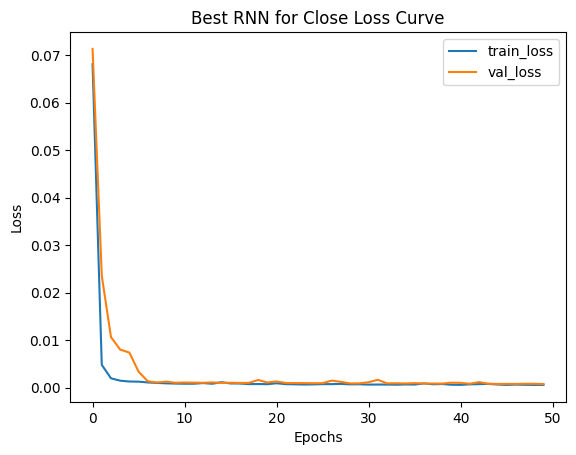

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


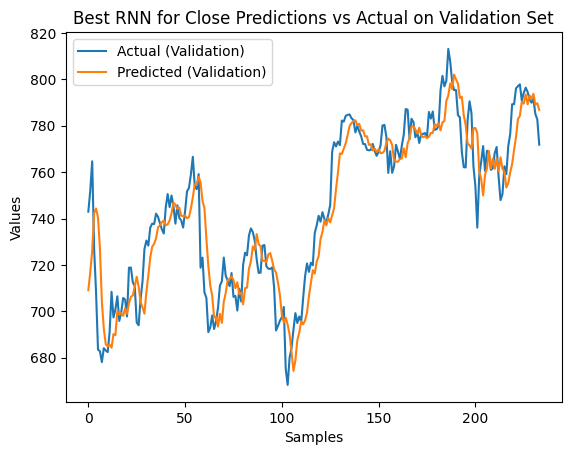

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Best RNN for Close Evaluation Metrics:
MAPE: 0.025431029498577118
RMSE: 20.388057708740234
R^2: -53.36968994140625
MAE: 20.327850341796875


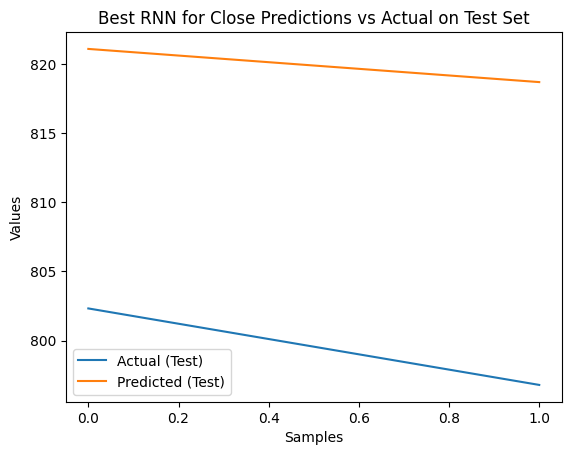

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.0597 - val_loss: 0.0040
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0060 - val_loss: 0.0011
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - val_loss: 0.0015
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0041 - val_loss: 8.7039e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0048 - val_loss: 8.5027e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.003

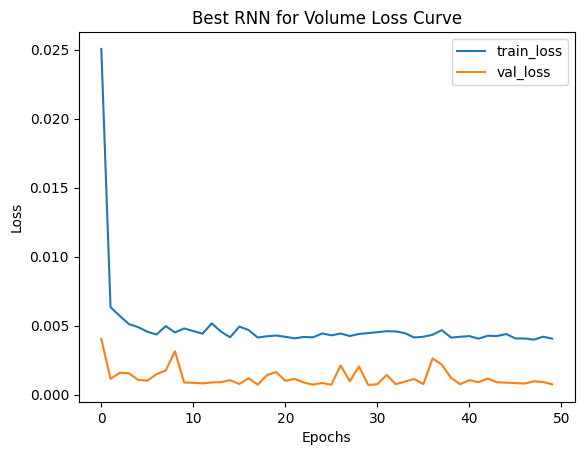

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


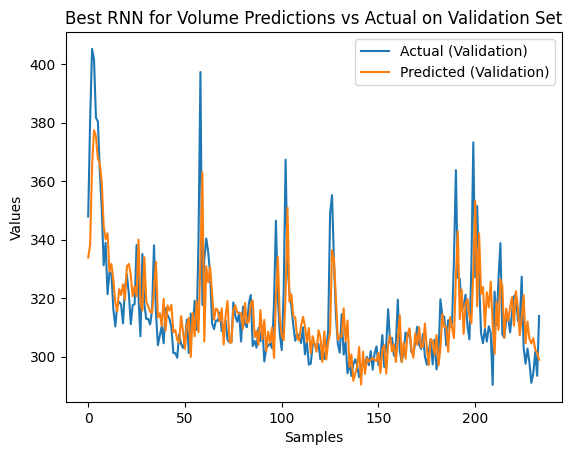

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Best RNN for Volume Evaluation Metrics:
MAPE: 0.038187652826309204
RMSE: 13.772750854492188
R^2: -0.6184484958648682
MAE: 12.845870971679688


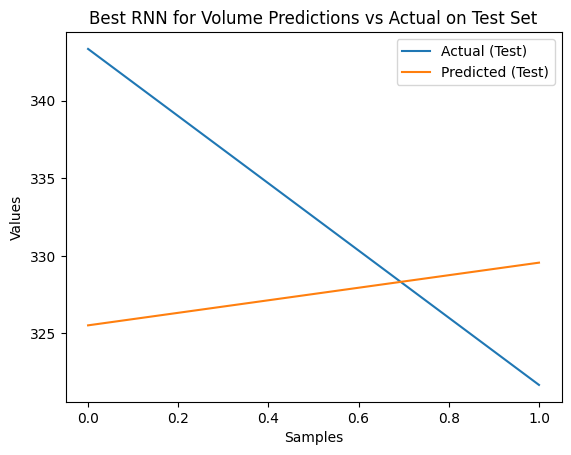

In [130]:
epochs = 50
batch_size = 32
# Build and evaluate the best RNN model for Close
best_rnn_model_close = build_rnn_model(best_rnn_params['units'], best_rnn_params['activation_function'],  best_rnn_params['learning_rate'], best_rnn_params['optimizer'])
train_and_evaluate(best_rnn_model_close, X_train_close, y_train_close, X_val_close, y_val_close, X_test_close, y_test_close, 'Best RNN for Close')

# Build and evaluate the best RNN model for Volume
best_rnn_model_volume = build_rnn_model(best_rnn_params['units'], best_rnn_params['activation_function'],  best_rnn_params['learning_rate'], best_rnn_params['optimizer'])
train_and_evaluate(best_rnn_model_volume, X_train_volume, y_train_volume, X_val_volume, y_val_volume, X_test_volume, y_test_volume, 'Best RNN for Volume')

#### 6.2 LSTM


In [123]:
# Function to build LSTM model
def build_lstm_model(units, activation_function, learning_rate, optimizer_name):
    model = Sequential()
    model.add(LSTM(units, activation=activation_function, return_sequences=True, input_shape=(X_train_close.shape[1], 1)))

    model.add(LSTM(units, activation=activation_function, return_sequences=True))

    model.add(LSTM(units, activation=activation_function))

    model.add(Dense(1))

    if optimizer_name == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_name == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    elif optimizer_name == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    else:
        raise ValueError(f'Unknown optimizer: {optimizer_name}')

    model.compile(optimizer=optimizer, loss='mse')
    return model

In [124]:
# Grid Search for LSTM model
best_lstm_score = float('inf')
best_lstm_params = None
for params in grid:
    print(f'Training LSTM with params: {params}')
    lstm_model = build_lstm_model(params['units'], params['activation_function'], params['learning_rate'], params['optimizer'])
    history = lstm_model.fit(X_train_close, y_train_close, validation_data=(X_val_close, y_val_close), epochs=epochs, batch_size=params['batch_size'], verbose=0, callbacks=[early_stopping])
    val_loss = history.history['val_loss'][-1]
    if val_loss < best_lstm_score:
        best_lstm_score = val_loss
        best_lstm_params = params

print(f'Best LSTM Params: {best_lstm_params}')

Training LSTM with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 32}


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Training LSTM with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 64}
Training LSTM with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'adam', 'units': 32}
Training LSTM with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.01, 'optimizer': 'adam', 'units': 64}
Training LSTM with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.1, 'optimizer': 'adam', 'units': 32}
Training LSTM with params: {'activation_function': 'tanh', 'batch_size': 32, 'learning_rate': 0.1, 'optimizer': 'adam', 'units': 64}
Training LSTM with params: {'activation_function': 'tanh', 'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 32}
Training LSTM with params: {'activation_function': 'tanh', 'batch_size': 64, 'learning_rate': 0.001, 'optimizer': 'adam', 'units': 64}
Training LSTM with params: {'activation_function': 'tanh', 'b

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 38ms/step - loss: 0.1393 - val_loss: 0.0039
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.0040 - val_loss: 0.0019
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0013 - val_loss: 0.0044
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 0.0019
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011 - val_loss: 0.0022
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0014 - val_loss: 0.0020
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0011 - val_loss: 0.0016
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0010 - val_loss: 0.0058
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0015 - val_l

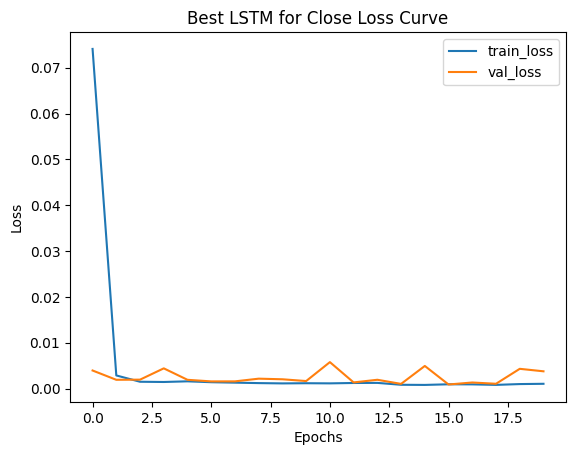

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


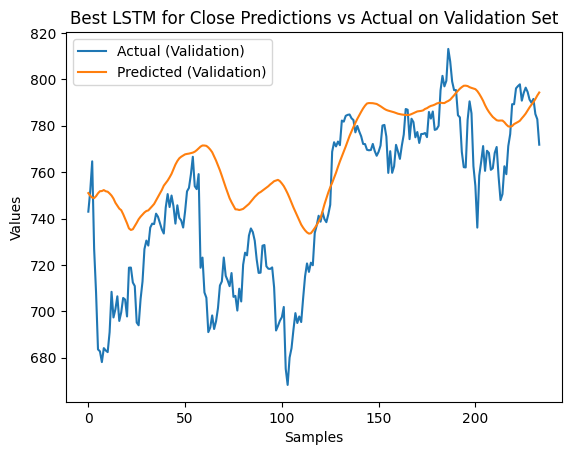

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Best LSTM for Close Evaluation Metrics:
MAPE: 0.006047614384442568
RMSE: 5.882392406463623
R^2: -3.525984764099121
MAE: 4.823699951171875


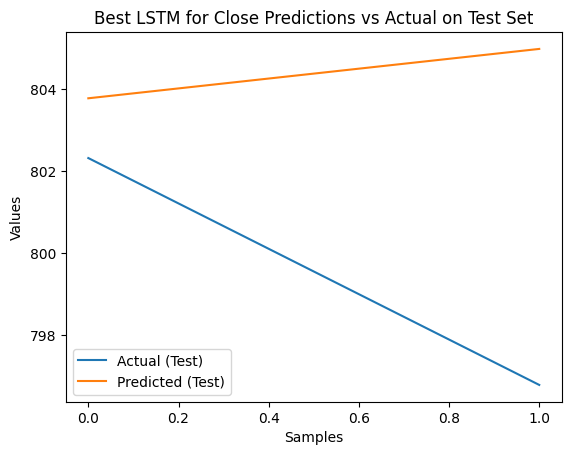

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - loss: 0.0221 - val_loss: 0.0021
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0074 - val_loss: 0.0014
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0050 - val_loss: 0.0021
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0059 - val_loss: 0.0019
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0060 - val_loss: 9.8251e-04
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0048 - val_loss: 0.0015
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0053 - val_loss: 9.0372e-04
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0048 - val_loss: 0.0011
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0040 - val_loss: 7.7729e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0044 - val_loss: 9.3401e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss

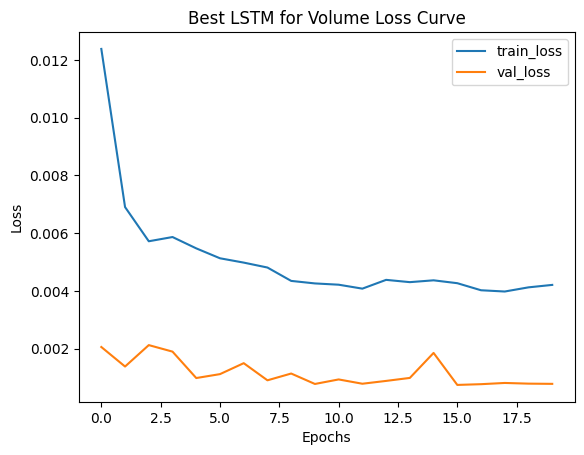

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 58ms/step


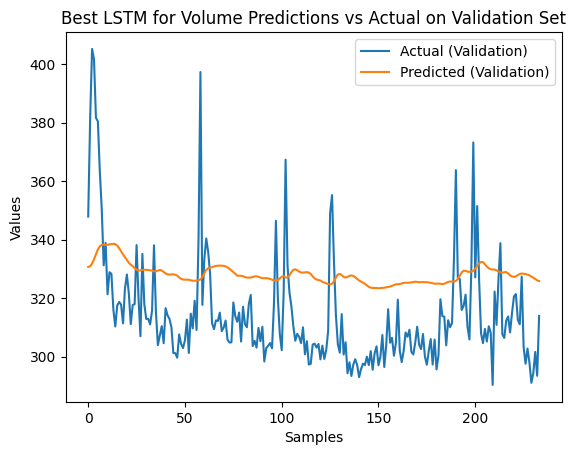

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Best LSTM for Volume Evaluation Metrics:
MAPE: 0.03313614800572395
RMSE: 12.596654891967773
R^2: -0.3538419008255005
MAE: 11.1943359375


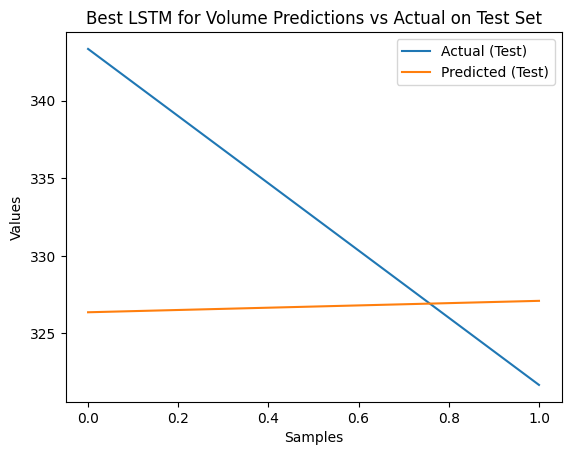

In [132]:
# Build and evaluate the best LSTM model for Close
best_lstm_model_close = build_lstm_model(best_lstm_params['units'], best_lstm_params['activation_function'],  best_lstm_params['learning_rate'], best_lstm_params['optimizer'])
train_and_evaluate(best_lstm_model_close, X_train_close, y_train_close, X_val_close, y_val_close, X_test_close, y_test_close, 'Best LSTM for Close')

# Build and evaluate the best LSTM model for Volume
best_lstm_model_volume = build_lstm_model(best_lstm_params['units'], best_lstm_params['activation_function'],  best_lstm_params['learning_rate'], best_lstm_params['optimizer'])
train_and_evaluate(best_lstm_model_volume, X_train_volume, y_train_volume, X_val_volume, y_val_volume, X_test_volume, y_test_volume, 'Best LSTM for Volume')

### 7.Best Model(RNN)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 7s 91ms/step - loss: 0.1474 - val_loss: 0.0713
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0056 - val_loss: 0.0236
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0021 - val_loss: 0.0106
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0016 - val_loss: 0.0080
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0012 - val_loss: 0.0074
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0014 - val_loss: 0.0034
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0010 - val_loss: 0.0014
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0010 - val_loss: 0.0013
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 8.3052e-04 - val_loss: 0.0010
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.9103e-04 - val_loss: 0.0011
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0011

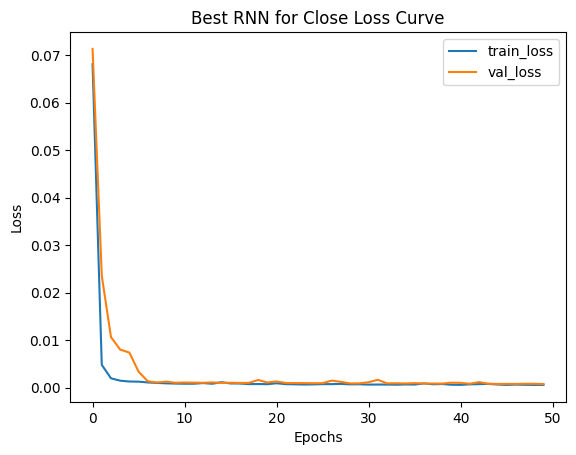

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step


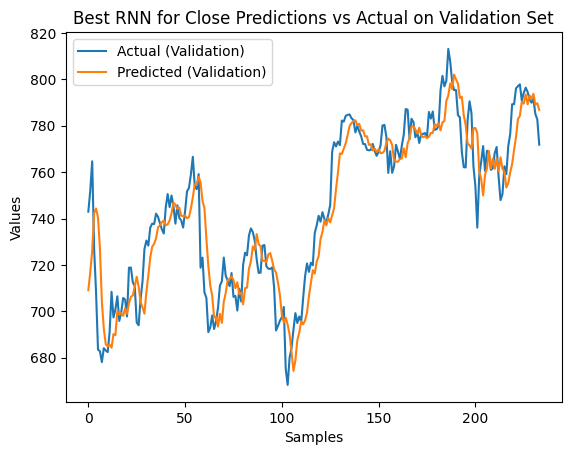

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
Best RNN for Close Evaluation Metrics:
MAPE: 0.025431029498577118
RMSE: 20.388057708740234
R^2: -53.36968994140625
MAE: 20.327850341796875


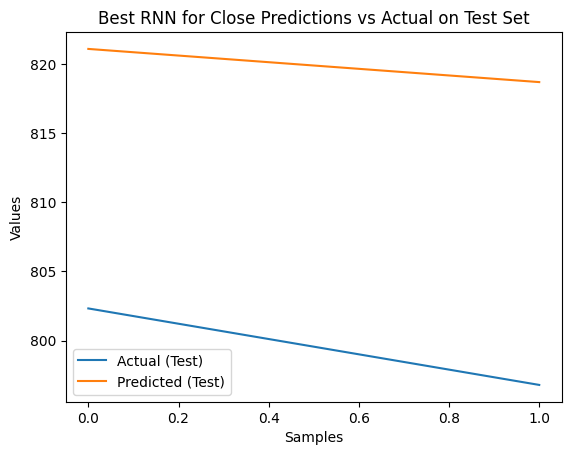

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 9s 103ms/step - loss: 0.0597 - val_loss: 0.0040
Epoch 2/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0060 - val_loss: 0.0011
Epoch 3/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - loss: 0.0048 - val_loss: 0.0016
Epoch 4/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0074 - val_loss: 0.0015
Epoch 5/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0041 - val_loss: 0.0011
Epoch 6/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0040 - val_loss: 0.0010
Epoch 7/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0039 - val_loss: 0.0015
Epoch 8/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0033 - val_loss: 0.0017
Epoch 9/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0051 - val_loss: 0.0031
Epoch 10/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0041 - val_loss: 8.7039e-04
Epoch 11/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0048 - val_loss: 8.5027e-04
Epoch 12/50
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.003

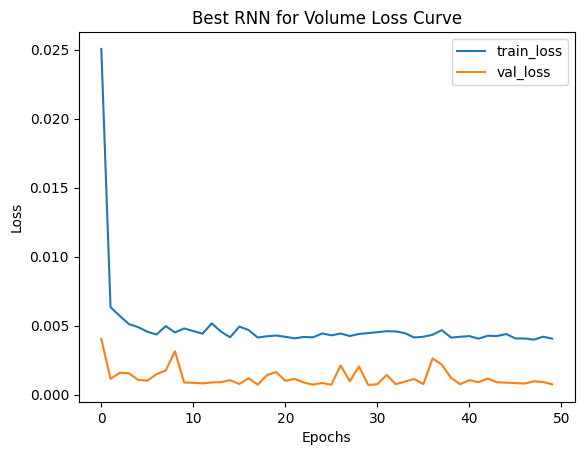

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 123ms/step


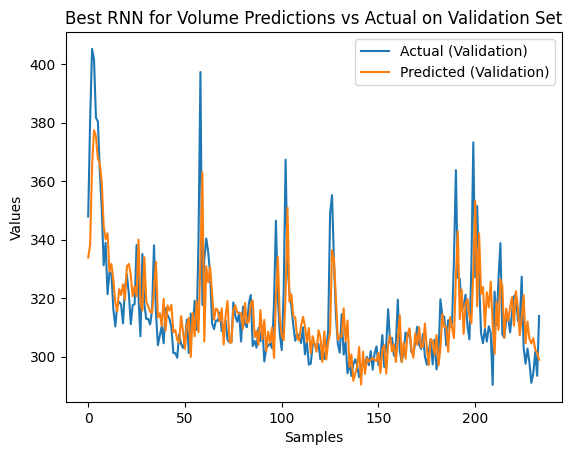

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
Best RNN for Volume Evaluation Metrics:
MAPE: 0.038187652826309204
RMSE: 13.772750854492188
R^2: -0.6184484958648682
MAE: 12.845870971679688


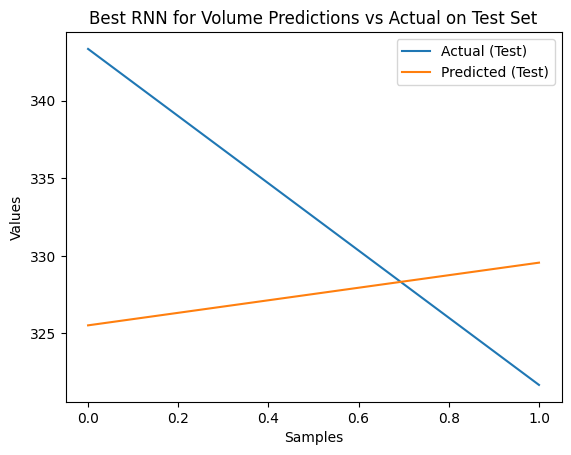

In [ ]:
epochs = 50
batch_size = 32
# Build and evaluate the best RNN model for Close
best_rnn_model_close = build_rnn_model(best_rnn_params['units'], best_rnn_params['activation_function'],  best_rnn_params['learning_rate'], best_rnn_params['optimizer'])
train_and_evaluate(best_rnn_model_close, X_train_close, y_train_close, X_val_close, y_val_close, X_test_close, y_test_close, 'Best RNN for Close')

# Build and evaluate the best RNN model for Volume
best_rnn_model_volume = build_rnn_model(best_rnn_params['units'], best_rnn_params['activation_function'],  best_rnn_params['learning_rate'], best_rnn_params['optimizer'])
train_and_evaluate(best_rnn_model_volume, X_train_volume, y_train_volume, X_val_volume, y_val_volume, X_test_volume, y_test_volume, 'Best RNN for Volume')